In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
1,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
2,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
3,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
4,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
...,...,...
1573,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal
1574,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal
1575,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal
1576,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal


In [5]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [6]:
test_df

,filepaths,labels
1445,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal
215,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
106,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
339,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
305,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
...,...,...
1178,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,malignant
1147,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,malignant
460,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,benign
1530,/content/drive/MyDrive/dataset/Dataset_BUSI_wi...,normal


In [7]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.


In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# # Load the pre-trained DenseNet201 model without the top classification layer
base_model = tf.keras.applications.DenseNet201(include_top=False,
                                               weights="imagenet",
                                               input_shape=img_shape,
                                               pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])



74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1757s 8s/step - accuracy: 0.5894 - loss: 8.4668 - val_accuracy: 0.7658 - val_loss: 7.3890
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 68s 188ms/step - accuracy: 0.7442 - loss: 4.1932 - val_accuracy: 0.7816 - val_loss: 3.5425
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.7612 - loss: 3.3458 - val_accuracy: 0.7911 - val_loss: 2.8392
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.7998 - loss: 2.7588 - val_accuracy: 0.7690 - val_loss: 2.3840
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.8512 - loss: 2.2773 - val_accuracy: 0.8671 - val_loss: 1.9556
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.8668 - loss: 1.9089 - val_accuracy: 0.8354 - val_loss: 1.7073
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.8954 - loss: 1.6289 - val_accuracy: 0.8481 - val_loss: 1.5074
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.8902 - loss: 1.

In [10]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9967 - loss: 0.2478
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9183 - loss: 0.4739
Train Loss:  0.24782077968120575
Train Accuracy:  0.996830403804779
--------------------
Test Loss:  0.5071445107460022
Test Accuracy:  0.9082278609275818


In [11]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step


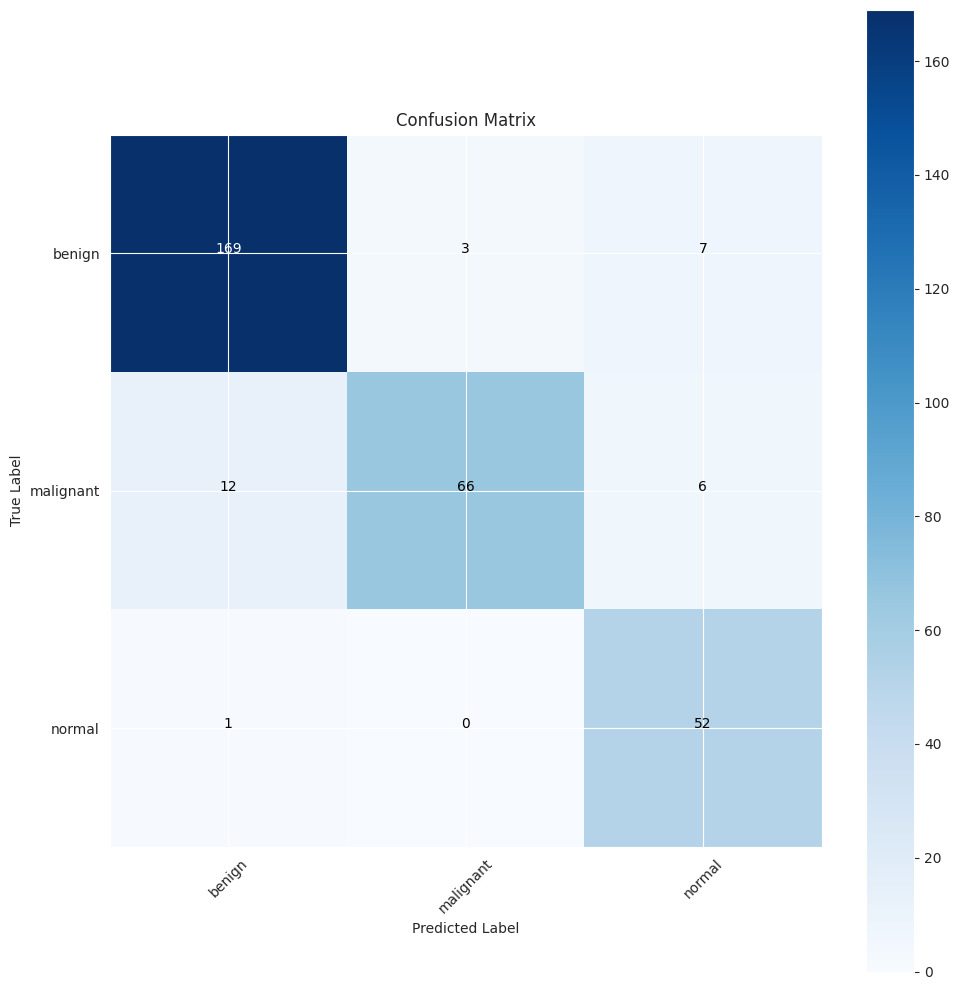

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.93      0.94      0.94       179
   malignant       0.96      0.79      0.86        84
      normal       0.80      0.98      0.88        53

    accuracy                           0.91       316
   macro avg       0.90      0.90      0.89       316
weighted avg       0.91      0.91      0.91       316



In [14]:
#Save the model
model.save('Model.h5')